<h1><center>IAGA Summer School 2019</center></h1>

# Calculating K-indices for a single observatory

The K-index was devised by Julius Bartels in 1938. It assigns a number in the range 0-9 to each 3-hour (UT) interval to give a simple measure of the degree of geomagnetic distrubance during that period. The K-index was introduced at the time of photographic recording and magnetograms recorded variation in the horizontal geomagnetic field elements declination (D) and horizontal intensity (H) and vertical intensity (Z). To derive a K-index an observer would fit, by eye, a quiet-time curve to the records of D and H and measure the range (maximum-minimum) of the deviation of the recording from the curve and then assign a K-index according to a conversion table, with The greatest range in D and H 'winning'. The north component (X) may be used instead of H, and the east component (Y) instead of D (X, Y will be used in the examples below). (Z is not used because it is liable to contamination by local induced currents.)

The conversion from range to index is quasi-logarithmic . The conversion table varies with latitude in an attempt to normalise the K-index distribution for observatories at different latitudes. The table for Eskdalemuir is shown below.

| K | 0 | 1 |2|3|4|5|6|7|8|9|
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Lower bound | 0 | 8 |15|30|60|105|180|300|500|750|

This means that, for instance, K=2 if the measured range is in the interval \[15, 30).

Here we **illustrate** the process. A simple approach is to assume the so-called regular daily variation $S_R$ is make up of 24h, 12h and 8h signals (and, possibly, higher harmonics). A Fourier analysis can be used to investigate this. The functions below are to calculate Fourier coefficients from a data sample, and then synthesise a Fourier series using the coefficients.

Some days this simple approach seems to work well, on others it's obviously wrong. Think about another approach you might take.

There was a VERY long debate in IAGA Division V about algorithms that could adequately reproduce the K-indices that an experienced observer would assign. The algorithms and code approved by IAGA are available at the International Service for Geomagnetic Indices: http://isgi.unistra.fr/softwares.php. (Also http://isgi.unistra.fr/what_are_kindices.php)

**Reference**
Menvielle, M. et al. (1995) ‘Computer production of K indices: review and comparison of methods’, Geophysical Journal International. Oxford University Press, 123(3), pp. 866–886. doi: 10.1111/j.1365-246X.1995.tb06895.x.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('C:\\PP\\Science\\python\\dk_libs')
import mag_lib as mag
d2r = np.deg2rad

def fourier(v, nhar):
    npts    = len(v)
    f       = 2.0/npts
    t       = np.linspace(0, npts, npts, endpoint=False)*2*np.pi/npts
    vmn     = np.mean(v)
    v       = v - vmn
    cofs    = [0]*(nhar+1)
    cofs[0] = (vmn,0)
    for i in range(1,nhar+1):
        c, s    = np.cos(i*t), np.sin(i*t)
        cofs[i] = (np.dot(v,c)*f, np.dot(v,s)*f)
    return (cofs)

def fourier_synth(cofs, npts):
    nt  = len(cofs)
    syn = np.zeros(npts)
    t  = np.linspace(0, npts, npts, endpoint=False)*2*np.pi/npts
    for n in range(1, nt):
        for j in range(npts):
            syn[j] += cofs[n][0]*np.cos(n*t[j]) + cofs[n][1]*np.sin(n*t[j])
    return (syn)

ModuleNotFoundError: No module named 'mag_lib'

Now load in (X, Y, Z) one-minute data from Eskdalemuir for 2003 into a pandas dataframe.

In [2]:
OBSY = 'ESK'
year ='2003'
npts = 1440 # Number of minutes in a day
df = mag.load_year('esk', 2003, 'E:\\geomag_data\\ESK\\2003\\')
df.columns = [col.strip(OBSY) for col in df.columns]
df = df.drop(['DOY', 'F'], axis=1)
ann_means = df[[f'{i}' for i in 'XYZ']].resample('1Y').mean()
df.head()

,X,Y,Z
DATE_TIME,,,
2003-01-01 00:00:00,17342.0,-1473.2,46197.8
2003-01-01 00:01:00,17341.5,-1473.4,46197.8
2003-01-01 00:02:00,17342.0,-1473.4,46197.8
2003-01-01 00:03:00,17342.2,-1473.8,46197.6
2003-01-01 00:04:00,17342.6,-1473.7,46197.6


We will attempt to calculate K-indices for the day selected by computing the Fourier series up the the number of harmonics selected by subtracting the synthetic harmonic signal from the data, then calculating 3-hr ranges and converting these into the corresponding K-index. To do this we will need the following functions.


In [3]:
def K_plot(d, synd, day, E):
    fig, ax = plt.subplots(2,1)
    plt.rcParams['figure.figsize'] = [15, 10]
    t = np.linspace(0, 1440, 1440, endpoint= False)/60
    ax[0].plot(t, d)
    ax[0].plot(t, synd, color='red')
    ax[0].set_xlabel('UT (h)', fontsize=14)
    ax[0].set_ylabel(f'{E} (nT)', fontsize=14)
    ax[0].xaxis.set_ticks(np.arange(0, 27, 3))
    ax[0].set_title(f'K-index estimation: {OBSY} {day}, ({E}-range: {np.ptp(d):.1f}nT)', fontsize=20)
    ax[1].plot(t, d-synd)
    ax[1].set_xlabel('UT (h)', fontsize=14)
    ax[1].set_ylabel(f'{E} residuals (nT)', fontsize=14)
    ax[1].xaxis.set_ticks(np.arange(0, 27, 3))
    fig.tight_layout()

def K_calc(d, synd, Kb):
    tmp = np.ptp((d-synd).reshape(8,180), axis=1)
    return(list(np.digitize(tmp,bins=list(Kb.values()), right=False)-1))

def K_load(obscode, year):
    kfile  = year + '.' + obscode
    filepath = 'C:\\PP\\Science\\python\\data\\k_inds\\'+ obscode + '\\'+ kfile
    df = pd.read_csv(filepath, skiprows=0, header=None, delim_whitespace=True,  
                      parse_dates=[[2,1,0]], index_col=0)
    df = df.drop(3, axis=1)
    df.index.name='Date'
    return(df)

**Now pick a day, and the number of harmonics to calculate. Return here to investigate different days.**


In [20]:
day  = '2003-10-29'
nhar = 3

First convert the D variations to units of nT using the annual mean value of H. Then calculate the daily means of D and H.

In [21]:
xmn  = df[day].X.mean()
ymn  = df[day].Y.mean()
xmn

17237.981388888893

Now analsye the X data.

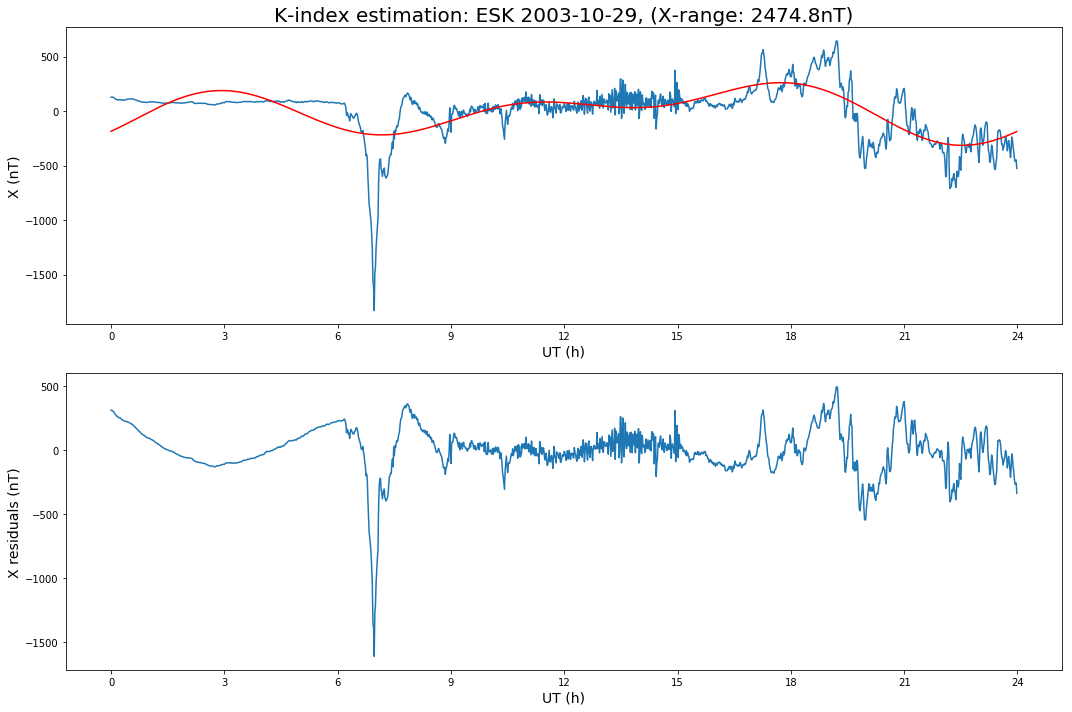

In [22]:
x     = df[day].X.values - xmn
xcofs = fourier(x, nhar)
synx  = fourier_synth(xcofs, npts)
K_plot(x, synx, day, 'X')

Now repeat for Y.

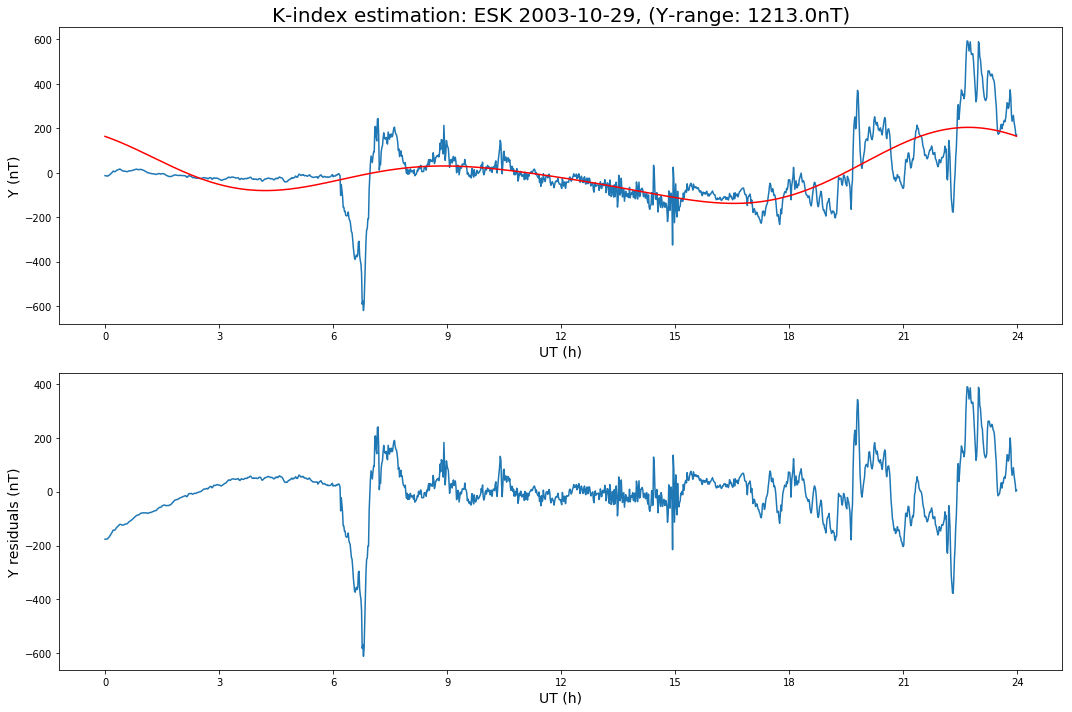

In [23]:
y     = df[day].Y.values - ymn
ycofs = fourier(y, nhar)
syny  = fourier_synth(ycofs, npts)
K_plot(y, syny, day, 'Y')

Calculate K-indice independently from the X and Y data, and load the official observatory values for comparison. (We also compute a daily sum of the K indices to use as a simple measure of quiet and disturbed days.)

In [24]:
K_lb   = [0, 8, 15, 30, 60, 105, 180, 300, 500, 750]
K_dict = dict(zip([f'{OBSY}_K{i}' for i in range (10)], K_lb))
Kx = K_calc(x, synx, K_dict)
Ky = K_calc(y, syny, K_dict)
Kf =[max(Kx[i], Ky[i]) for i in range(8)]

dfk   = K_load(OBSY.lower(), year)
dfk.columns = ['0','3','6','9','12','15','18','21']
K_obs = list(dfk.loc[day])
dfk['Ksum'] = dfk.sum(axis=1)
dfk.head()

,0,3,6,9,12,15,18,21,Ksum
Date,,,,,,,,,
2003-01-01,1,2,2,1,1,1,2,3,13
2003-01-02,2,0,0,1,1,1,2,2,9
2003-01-03,2,0,1,1,3,5,4,4,20
2003-01-04,4,4,2,2,2,2,3,3,22
2003-01-05,1,1,1,1,2,2,2,3,13


List the results.

In [25]:
print('K_X:     ', Kx)
print('K_Y:     ', Ky)
print('K_final: ', Kf)
print('K_obs:   ', K_obs)

K_X:      [7, 7, 9, 7, 8, 7, 9, 9]
K_Y:      [6, 3, 9, 6, 7, 6, 8, 9]
K_final:  [7, 7, 9, 7, 8, 7, 9, 9]
K_obs:    [4, 3, 9, 7, 8, 8, 9, 9]


List days with high and low values of Ksum. (These might be interesting days for you to look at.)

In [11]:
Ksort = dfk.sort_values('Ksum')
print('Quiet days: \n\n', Ksort.head(10), '\n\n')
print('Disturbed days: \n\n', Ksort.tail(10))

Quiet days: 

             0  3  6  9  12  15  18  21  Ksum
Date                                        
2003-10-11  1  0  0  0   1   0   0   0     2
2003-12-19  0  0  0  0   1   0   0   1     2
2003-12-18  1  1  0  0   1   0   0   0     3
2003-03-25  0  1  1  0   1   1   1   0     5
2003-12-25  1  0  0  0   2   1   0   1     5
2003-01-08  2  0  1  0   1   0   1   0     5
2003-01-09  0  0  0  0   0   1   2   2     5
2003-07-08  0  0  0  0   2   2   1   0     5
2003-10-12  0  0  0  1   1   0   2   2     6
2003-01-16  1  0  0  1   2   0   1   1     6 


Disturbed days: 

             0  3  6  9  12  15  18  21  Ksum
Date                                        
2003-09-17  4  5  4  4   5   5   4   5    36
2003-11-11  5  4  5  4   4   5   5   4    36
2003-02-02  5  4  4  4   4   6   5   5    37
2003-05-30  7  5  3  3   4   6   5   5    38
2003-05-29  3  3  3  2   6   6   7   8    38
2003-08-18  5  5  5  5   6   6   6   5    43
2003-11-20  1  3  5  4   7   9   9   8    46
2003-10-31  9  6  

## Note on the Fast Fourier Transform



In the examples above we computed Fourier coefficients in the 'traditional' way, so that if $F(t)$ is a Fourier series representation of $f(t)$, then,

$$
\begin{align}
F(t) &= A_o+\sum_{n=1}^N A_n \cos\left(\frac{2\pi nt}{T}\right)+B_n \sin\left(\frac{2\pi nt}{T}\right)
\end{align}
$$

where $T$ is the fundamental period of $F(t)$. The $A_n$ and $B_n$ are estimated by,

$$
\begin{align}
A_o&=\frac{1}{T}\int_0^T f(t) dt\\
A_n&=\frac{2}{T}\int_0^T f(t)\cos\left(\frac{2\pi nt}{T}\right) dt\\
B_n&=\frac{2}{T}\int_0^T f(t)\sin\left(\frac{2\pi nt}{T}\right) dt
\end{align}
$$

With $N$ samples of digital data the integral for $A_n$ may be replaced by the summation,

$$
\begin{align}
A_n&=\frac{2}{T}\sum_{j=0}^{N-1} f_j\cos\left(\frac{2\pi nj\Delta t}{T}\right) \Delta t\\
&=\frac{2}{N}\sum_{j=0}^{N-1} f_j\cos\left(\frac{2\pi nj}{N}\right)
\end{align}
$$

where the sampling interval $\Delta t$ is given by $T = N \Delta t$ and $f_j = f(j \Delta t)$. A simliar expression applies for the $B_n$, and these are the coefficients returned by the function _fourier_ above.

The fast Fourier transform (FFT) offers a computationally efficient means of finding the Fourier coefficients. The conventions for the FFT and its inverse (IFFT) vary from package to package. In the _scipy.fftpack_ package the FFT of a sequence $x_n$ of length $N$ is defined as,

$$
\begin{align}
y_k&=\sum_{n=0}^{N-1} x_n\exp\left(-\frac{2\pi i\thinspace kn}{N}\right)\\
&=\sum_{n=0}^{N-1} x_n\left(\cos\left(\frac{2\pi \thinspace kn}{N}\right)-i\sin\left(\frac{2\pi \thinspace kn}{N}\right)\right)
\end{align}
$$

with the inverse defined as,

$$
\begin{align}
x_n&=\frac{1}{N}\sum_{k=0}^{N-1} y_k\exp\left(\frac{2\pi i\thinspace kn}{N}\right)\\
\end{align}
$$

The _scipy_ documentation is a little inconsistent here as it explains the order of the $y_n$ as being $y_1,y_2, \dots y_{N/2-1}$ as corresponding to increasing positive frequency and $y_{N/2}, y_{N/2+1}, \dots y_{N-1}$ as ordered by decreasing negative frequency, for $N$ even. (See: https://docs.scipy.org/doc/scipy/reference/tutorial/fftpack.html.)

The interpretation is that if $y_k=a_k+ib_k$ then will have (for $N$ even), $y_{N-k} = a_k-ib_k$ and so

$$
\begin{align}
a_k&=\frac{1}{2}\text{Re}\left(y_k+y_{N-k}\right)\\
b_k&=\frac{1}{2}\text{Im}\left(y_k-y_{N-k}\right)
\end{align}
$$


and so we expect the relationship to the digitised Fourier series coefficients returned by the function _fourier_ defined above to be,

$$
\begin{align}
A_k&=\phantom{-}\frac{1}{N}\text{Re}\left(a_k+a_{N-k}\right)\\
B_k&=-\frac{1}{N}\text{Im}\left(b_k-b_{N-k}\right)
\end{align}
$$

In [18]:
# Compute the fft of the x data
from scipy.fftpack import fft
xfft = fft(x)

# Compare results for the 24-hour component
k    = 1
print('Fourier coefficients: \n', f'A1 = {xcofs[1][0]} \n', f'B1 = {xcofs[1][1]} \n')
print('scipy FFT outputs: \n', f'a1 = {np.real(xfft[k]+xfft[npts-k])/npts} \n', \
      f'b1 = {-np.imag(xfft[k]-xfft[npts-k])/npts} \n')

Fourier coefficients: 
 A1 = 1.9222474131097547 
 B1 = 7.835093862256126 

scipy FFT outputs: 
 a1 = 1.9222474131097538 
 b1 = 7.835093862256124 



In [19]:
df['Ksum']=dfk['Ksum'].reindex(df.index, method='ffill')
df.head()

,X,Y,Z,Ksum
DATE_TIME,,,,
2003-01-01 00:00:00,17342.0,-1473.2,46197.8,13
2003-01-01 00:01:00,17341.5,-1473.4,46197.8,13
2003-01-01 00:02:00,17342.0,-1473.4,46197.8,13
2003-01-01 00:03:00,17342.2,-1473.8,46197.6,13
2003-01-01 00:04:00,17342.6,-1473.7,46197.6,13
